# Step 3: Visualizations

In [1]:
# Retrieve the dataframe and clusters using %store
%store -r df clusters

## Wordclouds

For each defined cluster, a wordcloud with the most frequent words is created to gain a better understanding of the underlying content.

In [2]:
from collections import Counter

# Convert any non-string values to strings
df['abstract'] = df['abstract'].apply(lambda x: ' '.join(x) if isinstance(x, list) else x)

# Concatenate abstracts of all papers
all_abstracts = ' '.join(df['abstract'])

# Tokenize the abstracts
words = all_abstracts.split()

# Count word frequencies
word_freq = Counter(words)

# Get the top 10 most frequent words
top_10_words = [word for word, freq in word_freq.most_common(10)]

print("Top 10 most frequent words across all abstracts:")
print(top_10_words)


Top 10 most frequent words across all abstracts:
['model', 'learning', 'data', 'method', 'network', 'approach', 'algorithm', 'using', 'performance', 'neural']


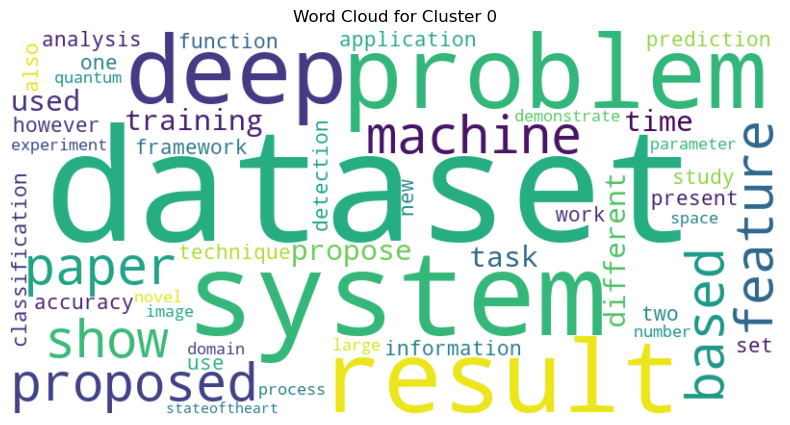

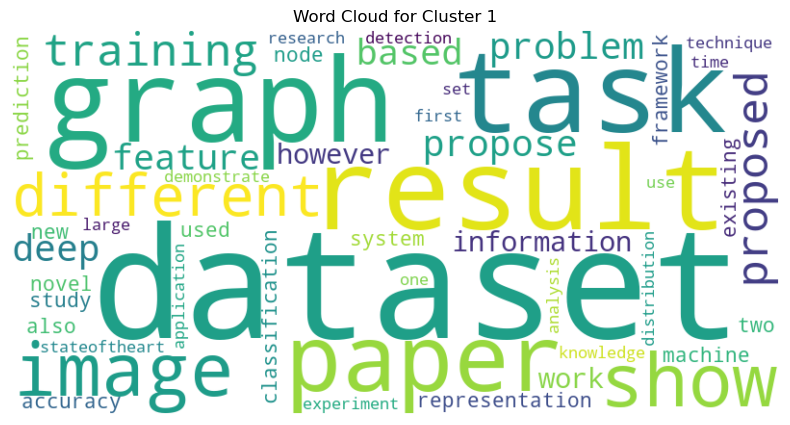

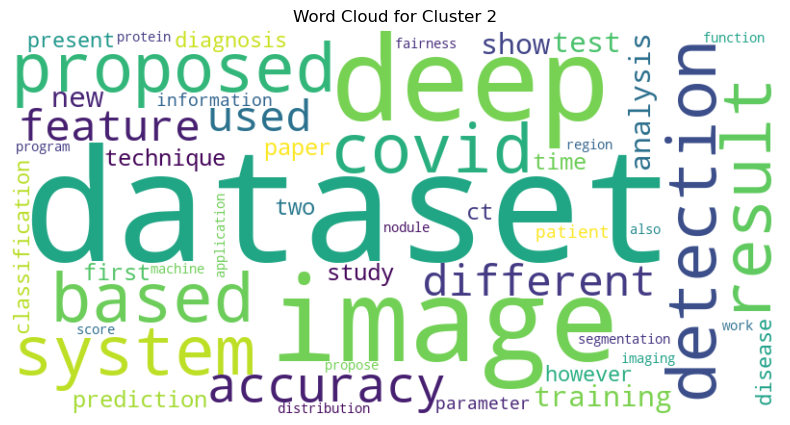

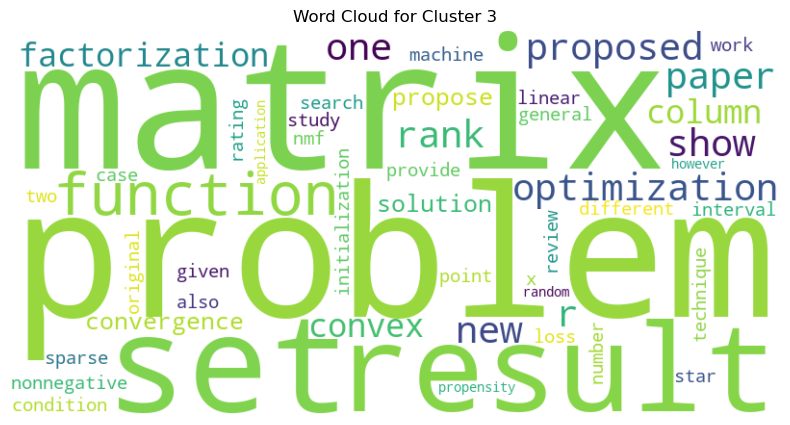

In [3]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter

# Function to extract top frequent words for each cluster
def extract_top_frequent_words(df, top_10_words, top_n=50):
    top_frequent_words_per_cluster = {}
    for cluster_label, group in df.groupby('cluster'):
        # Concatenate abstracts of papers in the cluster
        cluster_abstracts = ' '.join(group['abstract'])
        # Tokenize the abstracts
        words = cluster_abstracts.split()
        # Count word frequencies
        word_freq = Counter(words)
        # Exclude the top N most frequent words across all abstracts
        for word in top_10_words:
            if word in word_freq:
                del word_freq[word]
        # Get the top N frequent words for this cluster
        top_words = [word for word, freq in word_freq.most_common(top_n)]
        # Store the top N frequent words for this cluster
        top_frequent_words_per_cluster[cluster_label] = top_words
    return top_frequent_words_per_cluster

# Function to generate word cloud from a list of words
def generate_word_cloud(words, cluster_label, top_10_words):
    # Convert list of words to a string
    text = ' '.join(words)
    # Generate word cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white', stopwords=top_10_words).generate(text)
    # Plot word cloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Word Cloud for Cluster {cluster_label}')
    plt.axis('off')
    plt.show()

# Extract top frequent words for each cluster
top_frequent_words_per_cluster = extract_top_frequent_words(df, top_10_words)

# Generate word clouds for each cluster
for cluster_label, top_words in top_frequent_words_per_cluster.items():
    generate_word_cloud(top_words, cluster_label, top_10_words)
    print()


### Naming of Clusters

In [4]:
import numpy as np

# Create a dictionary mapping cluster labels to cluster names
cluster_names = {
    0: 'Foundations of Machine Learning & Training Techniques',
    1: 'Graph & Representation Learning',
    2: 'Medical Imaging & Diagnosis',
    3: 'Mathematical Optimization & Theory',
}

# Create an array to store the cluster names corresponding to each label
cluster_names_arr = np.array([cluster_names[label] for label in clusters])

# Add a new column 'cluster' to the DataFrame with the cluster names
df['cluster_name'] = cluster_names_arr

/var/folders/7x/z_208mgn0nsf7_qfx12cshlh0000gn/T/ipykernel_65066/1148780287.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['cluster_name'] = cluster_names_arr


## Distribution of Papers
This visualization shows the total number of papers being assigned to each cluster.

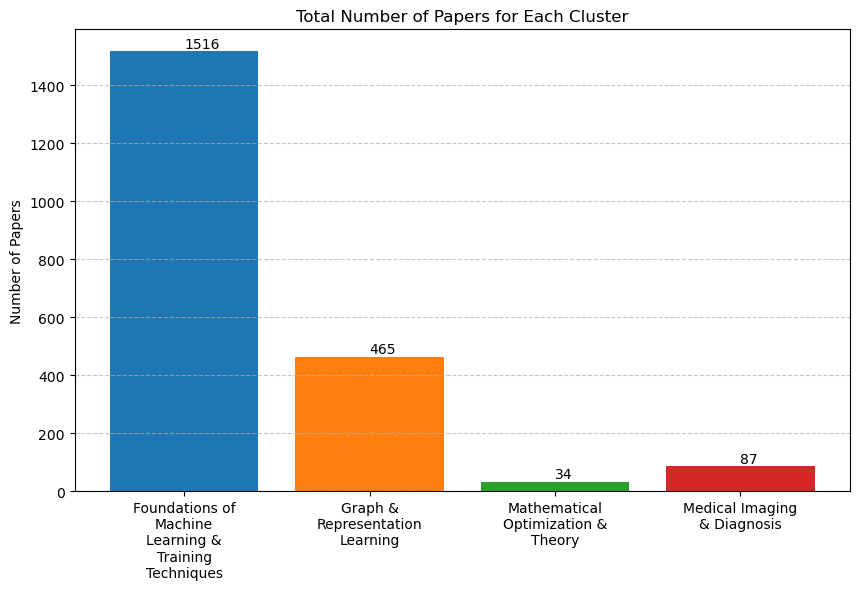

In [5]:
import textwrap

# Get the default color cycle
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

# Calculate the total number of papers for each cluster
cluster_counts = df['cluster_name'].value_counts().sort_index()

# Plot the bar chart
plt.figure(figsize=(10, 6))
bars = plt.bar(cluster_counts.index, cluster_counts.values, color=colors)
plt.title('Total Number of Papers for Each Cluster')
plt.xlabel('')
plt.ylabel('Number of Papers')

# Wrap x-axis labels with line breaks
wrapped_labels = [textwrap.fill(str(label), 15) for label in cluster_counts.index]
plt.xticks(cluster_counts.index, wrapped_labels)

# Add values for each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 1), va='bottom')

plt.grid(axis='y', linestyle='--', alpha=0.7) 
plt.show()

## Temporal Analysis
This visualization shows the for each cluster the number of published papers for each year.

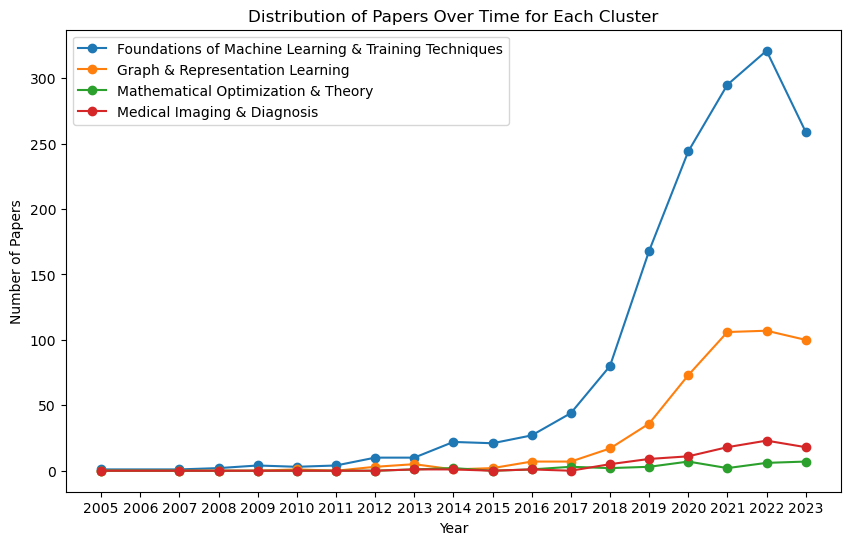

In [6]:
import pandas as pd

# Group DataFrame by cluster labels and publication dates
df['created_date'] = pd.to_datetime(df['created_date'])
papers_by_cluster_year = df.groupby([df['cluster_name'], df['created_date'].dt.year]).size().unstack(fill_value=0)

# Plot the distribution of papers over time for each cluster
plt.figure(figsize=(10, 6))
for cluster in papers_by_cluster_year.index:
    plt.plot(papers_by_cluster_year.loc[cluster], label=f'{cluster}', marker='o')

plt.title('Distribution of Papers Over Time for Each Cluster')
plt.xlabel('Year')
plt.ylabel('Number of Papers')
plt.xticks(range(int(df['created_date'].dt.year.min()), int(df['created_date'].dt.year.max()) + 1))
plt.legend()
plt.show()

## Distribution of main categories amongs each cluster
This visualization shows to which main categories the papers in each cluster belong to.

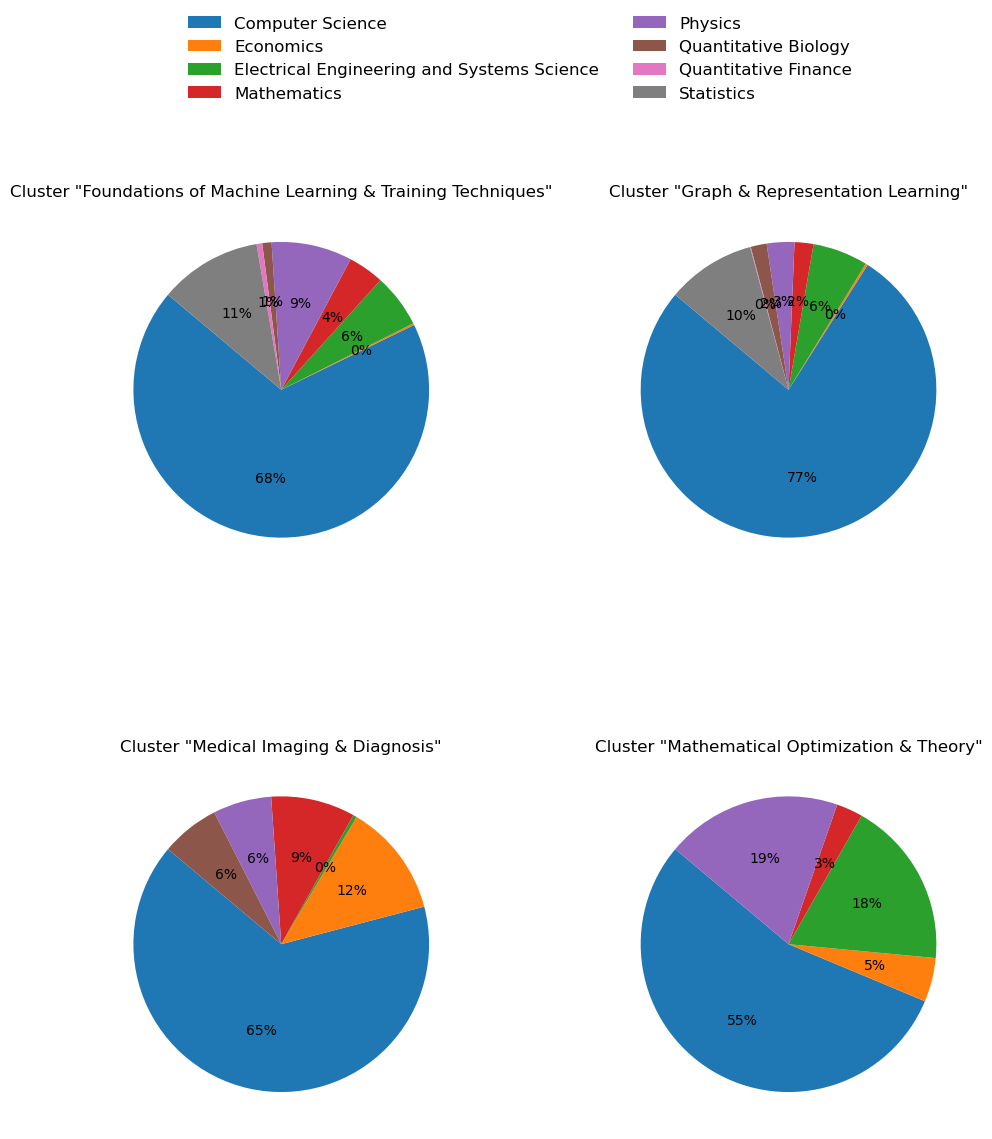

In [18]:
# Retrieve the dictionary using %store
%store -r taxonomy_data

# Get all main category names
main_categories = list(taxonomy_data.keys())

# Get the number of clusters and calculate the number of rows and columns needed
num_clusters = len(cluster_names)
num_rows = num_clusters // 2
num_cols = num_clusters // num_rows

# Create subplots with increased vertical spacing
fig, axs = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(12, 12), sharey=True, sharex=True, gridspec_kw={'hspace': 0.5})

# Flatten the axis array for easier iteration
axs = axs.flatten()

# Initialize handles and labels for legend
handles, labels = [], []

# Iterate over each cluster
for i, (cluster_name, ax) in enumerate(zip(cluster_names.values(), axs)):
    # Filter DataFrame to include only papers belonging to the current cluster
    cluster_data = df[df['cluster_name'] == cluster_name]
    
    # Initialize a dictionary to store the counts of papers in each main category
    main_category_counts = {}
    
    # Iterate over main categories
    for main_category in main_categories:
        # Get the list of subcategories within the current main category
        subcategories = taxonomy_data[main_category]
        
        # Calculate the total number of papers belonging to the current main category in the cluster
        main_category_count = sum(cluster_data[subcategory['short_name']].sum() for subcategory in subcategories)
        
        # Store the count in the dictionary if it's non-zero
        if main_category_count > 0:
            main_category_counts[main_category] = main_category_count
    
    # Convert the dictionary to a pandas Series for easier plotting
    main_category_series = pd.Series(main_category_counts)
    
    # Plotting
    patches, texts, _ = ax.pie(main_category_series, autopct='%1.0f%%', startangle=140)
    ax.set_title(f'Cluster "{cluster_name}"', fontsize=12) 
    ax.set_ylabel('')  # Hide the y-label
    ax.tick_params(axis='both', which='major', labelsize=12)  
    
    # Store the handles and labels for legend only in the first iteration
    if i == 0:
        handles.extend(patches)
        labels.extend(main_category_series.index)

# Add legend at the top with adjusted font size and frame
legend = fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=2, fontsize=12)  
legend.get_frame().set_linewidth(0)

# Save the figure with tight layout
plt.savefig('output.png', bbox_inches='tight')

# Show the plot
plt.show()

## Development of top title-keywords
This visualization displays the temporal development of the top 5 used keywords in titles.

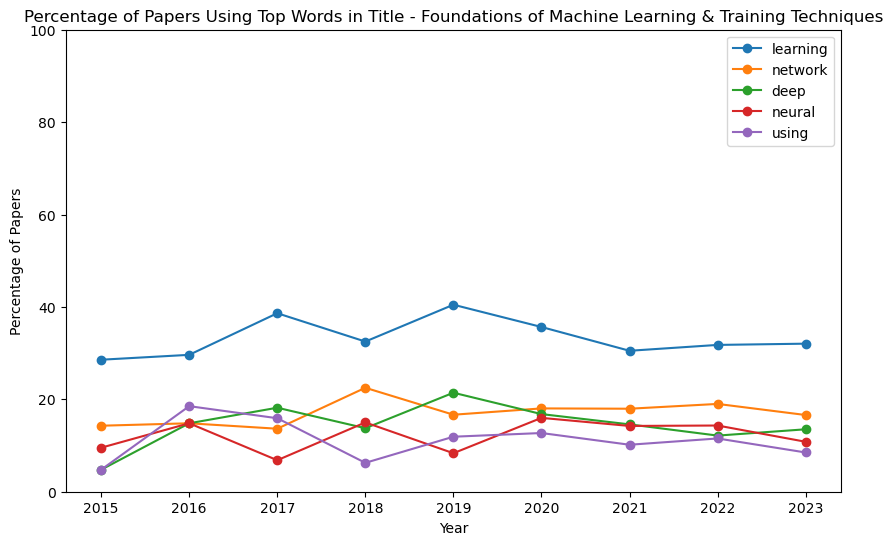

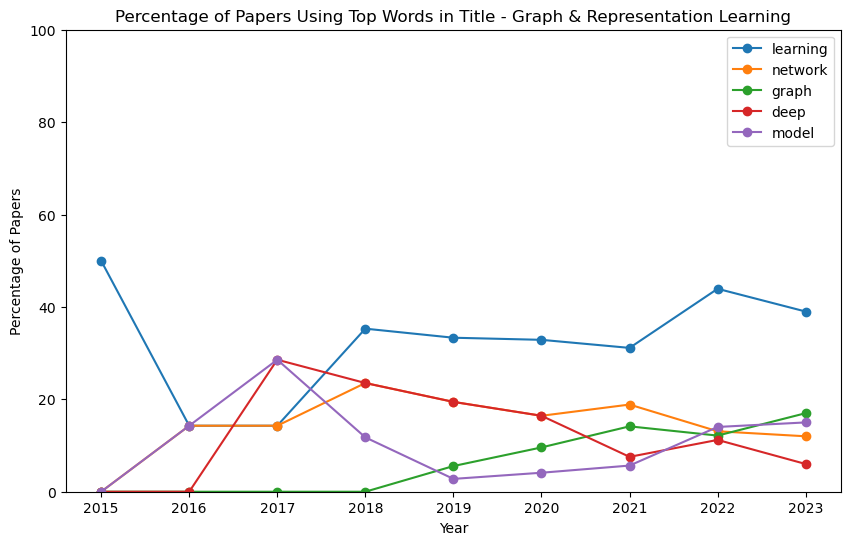

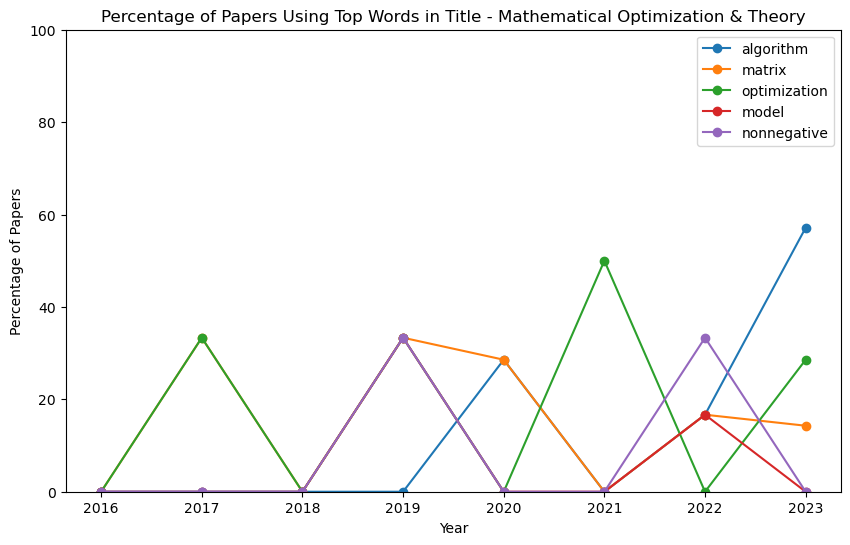

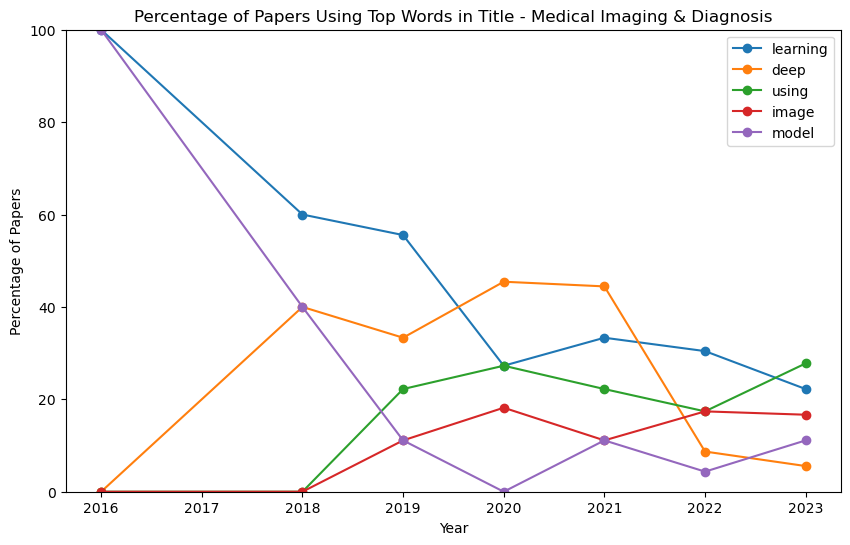

In [19]:
# Define a function to extract the top 5 title keywords in each cluster
def extract_top_frequent_titlewords(df, top_n=5):
    top_frequent_titlewords_per_cluster = {}
    for cluster_label, group in df.groupby('cluster_name'):
        # Concatenate titles of papers in the cluster
        cluster_titles = ' '.join([' '.join(title) for title in group['title']])
        # Tokenize the titles
        words = cluster_titles.split()
        # Count word frequencies
        word_freq = Counter(words)
        # Get the top N frequent words for this cluster
        top_words = [word for word, freq in word_freq.most_common(top_n)]
        # Store the top N frequent words for this cluster
        top_frequent_titlewords_per_cluster[cluster_label] = top_words
    return top_frequent_titlewords_per_cluster

# Call the function
top_words_per_cluster = extract_top_frequent_titlewords(df)

# Define a function to count the occurrences of each word in the titles for a specific cluster in each year
def count_word_occurrences_in_year(cluster_df, word):
    occurrences_in_year = []
    for year, group in cluster_df.groupby('created_year'):
        total_papers_in_year = len(group)
        papers_with_word = sum(1 for title in group['title'] if word in title)
        percentage = (papers_with_word / total_papers_in_year) * 100 if total_papers_in_year != 0 else 0
        occurrences_in_year.append((year, percentage))
    return occurrences_in_year

# Plot line charts for each cluster
for cluster, top_words in top_words_per_cluster.items():
    cluster_df = df[df['cluster_name'] == cluster]
    plt.figure(figsize=(10, 6))
    plt.title(f"Percentage of Papers Using Top Words in Title - {cluster}")
    plt.xlabel("Year")
    plt.ylabel("Percentage of Papers")

    for word in top_words:
        occurrences_in_year = count_word_occurrences_in_year(cluster_df, word)
        years, percentages = zip(*occurrences_in_year)
        years_filtered = [year for year in years if year > 2014]  # Filter years greater than 2014
        percentages_filtered = [percentage for year, percentage in occurrences_in_year if year > 2014]
        plt.plot(years_filtered, percentages_filtered, label=word, marker='o')

    plt.legend()
    plt.ylim(0, 100)  # Set y-axis limit to ensure it displays percentages
    plt.show()